In [3]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from google.colab import drive
import re
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import xgboost as xgb
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Function to clean tweets
def clean_tweet(tweet):
    # Remove URLs in tweets
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove mentions (usernames) in tweets
    tweet = re.sub(r'@\w+', '', tweet)

    # Normalize excessive punctuation in tweets
    tweet = re.sub(r'!+', '!', tweet)
    tweet = re.sub(r'\?+', '?', tweet)

    # Remove extra spaces from tweets
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [ ]:
# Create Dataframe for biden tweets
biden_df = pd.read_csv('hashtag_joebiden.csv')
# Create Dataframe for trump tweets
trump_df = pd.read_csv('hashtag_donaldtrump.csv', engine='python', on_bad_lines='skip')
# Print the lengths of dataframes
print(len(biden_df))
print(len(trump_df))

# Drop duplicate values from dataframes and print lengths
biden_df = biden_df.drop_duplicates()
trump_df = trump_df.drop_duplicates()
print(len(biden_df))
print(len(trump_df))

# Drop the user_name column for both dataframes
biden_df = biden_df.drop(columns=['user_name'])
trump_df = trump_df.drop(columns=['user_name'])

biden_df = biden_df.dropna()
trump_df = trump_df.dropna()
print(len(biden_df))
print(len(trump_df))

# Print the info of both Dataframes
print('Joe Biden Tweet DataFrame')
biden_df.info()
print('Donald Trump Tweet DataFrame')
trump_df.info()

<ipython-input-18-49b8dc90aee5>:2: DtypeWarning: Columns (1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  biden_df = pd.read_csv('hashtag_joebiden.csv')


1059909
971087
777010
971082
155945
189268
Joe Biden Tweet DataFrame
<class 'pandas.core.frame.DataFrame'>
Index: 155945 entries, 6 to 1059899
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            155945 non-null  object 
 1   tweet_id              155945 non-null  object 
 2   tweet                 155945 non-null  object 
 3   likes                 155945 non-null  object 
 4   retweet_count         155945 non-null  float64
 5   source                155945 non-null  object 
 6   user_id               155945 non-null  object 
 7   user_screen_name      155945 non-null  object 
 8   user_description      155945 non-null  object 
 9   user_join_date        155945 non-null  object 
 10  user_followers_count  155945 non-null  object 
 11  user_location         155945 non-null  object 
 12  lat                   155945 non-null  object 
 13  long                  155945 non-null  

In [ ]:
# Convert all tweets to lowercase
biden_df['tweet'] = biden_df['tweet'].str.lower()
trump_df['tweet'] = trump_df['tweet'].str.lower()

# Print the shape of both DataFrames
print('Biden shape:',biden_df.shape)
print('Trump shape:',trump_df.shape)

# Print the column names
print(biden_df.columns)
print(trump_df.columns)

# Display the first 5 rows
print(biden_df.head())
print(trump_df.head())

# Display the last 5 rows
print(biden_df.tail())
print(trump_df.tail())

# Display the data types of each column
print(biden_df.dtypes)
print(trump_df.dtypes)

Biden shape: (155945, 20)
Trump shape: (189268, 20)
Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_screen_name', 'user_description', 'user_join_date',
       'user_followers_count', 'user_location', 'lat', 'long', 'city',
       'country', 'continent', 'state', 'state_code', 'collected_at'],
      dtype='object')
Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_screen_name', 'user_description', 'user_join_date',
       'user_followers_count', 'user_location', 'lat', 'long', 'city',
       'country', 'continent', 'state', 'state_code', 'collected_at'],
      dtype='object')
             created_at                tweet_id  \
6   2020-10-15 00:00:25  1.3165293244182405e+18   
17  2020-10-15 00:01:23  1.3165295693614694e+18   
25  2020-10-15 00:01:57  1.3165297093714616e+18   
28  2020-10-15 00:02:05  1.3165297436306555e+18   
29  2020-10-15 00:02:06  1.3165297461095096e+18   

     

In [ ]:
# Clean the tweets in both DataFrames
biden_df['tweet'] = biden_df['tweet'].apply(clean_tweet)
trump_df['tweet'] = trump_df['tweet'].apply(clean_tweet)

# Apply word tokenization to both DataFrames
biden_df['tokens'] = biden_df['tweet'].apply(word_tokenize)
trump_df['tokens'] = trump_df['tweet'].apply(word_tokenize)

# Function to lemmatize tokens and remove stopwords
def lemmatize_and_remove_stopwords(tokens):
    return [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words and word not in string.punctuation]

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Apply lemmatization and remove stop words from both DataFrames
biden_df['tokens'] = biden_df['tokens'].apply(lemmatize_and_remove_stopwords)
trump_df['tokens'] = trump_df['tokens'].apply(lemmatize_and_remove_stopwords)

# Print first 5 rows of both DataFrames, ensure consistency
print(biden_df[['tweet', 'tokens']].head())
print(trump_df[['tweet', 'tokens']].head())

                                                tweet  \
6   in 2020, #nypost is being #censorship #censore...   
17  comments on this? "do democrats understand how...   
25  #bidencrimefamily #joebiden #hunterbiden #hunt...   
28  #trump #obama #clinton #biden #manwomanpersonc...   
29  come on please do the right thing. move the #b...   

                                               tokens  
6   [2020, nypost, censorship, censored, twitter, ...  
17  [comment, ``, democrat, understand, ruthless, ...  
25  [bidencrimefamily, joebiden, hunterbiden, hunt...  
28  [trump, obama, clinton, biden, manwomanpersonc...  
29  [come, please, right, thing, move, biden, town...  
                                                tweet  \
2   #trump: as a student i used to hear for years,...   
4   you get a tie! and you get a tie! #trump ‘s ra...   
11  in 2020, #nypost is being #censorship #censore...   
12  #trump #presidenttrump #trump2020landslidevict...   
13  #ukraine impeachment #factcheck 

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis
def get_sentiment_score(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to each tweet in both DataFrames
biden_df['sentiment'] = biden_df['tweet'].apply(get_sentiment_score)
trump_df['sentiment'] = trump_df['tweet'].apply(get_sentiment_score)

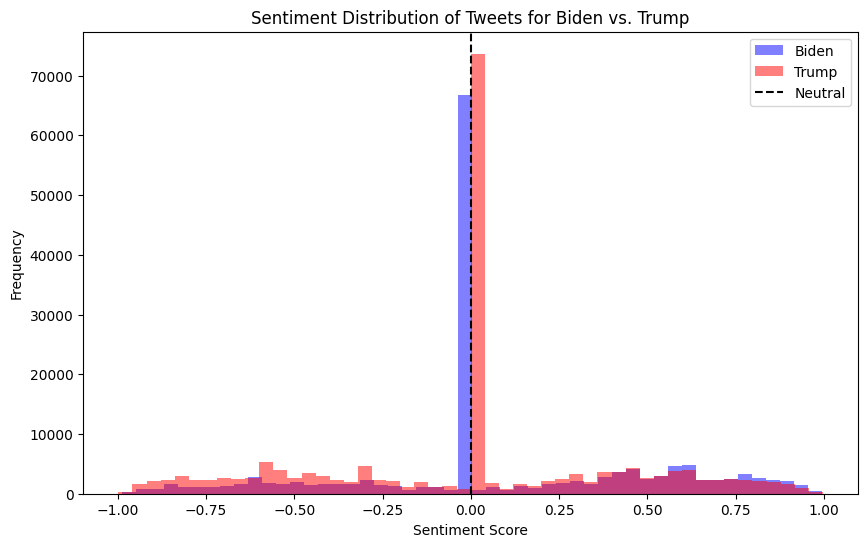

In [ ]:
# Visualize sentiment distribution for both candidates
plt.figure(figsize=(10, 6))

# Plot histograms for sentiment scores
plt.hist(biden_df['sentiment'], bins=50, alpha=0.5, label='Biden', color='blue')
plt.hist(trump_df['sentiment'], bins=50, alpha=0.5, label='Trump', color='red')

plt.axvline(x=0, color='black', linestyle='--', label='Neutral')  # Neutral line
plt.legend()
plt.title('Sentiment Distribution of Tweets for Biden vs. Trump')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

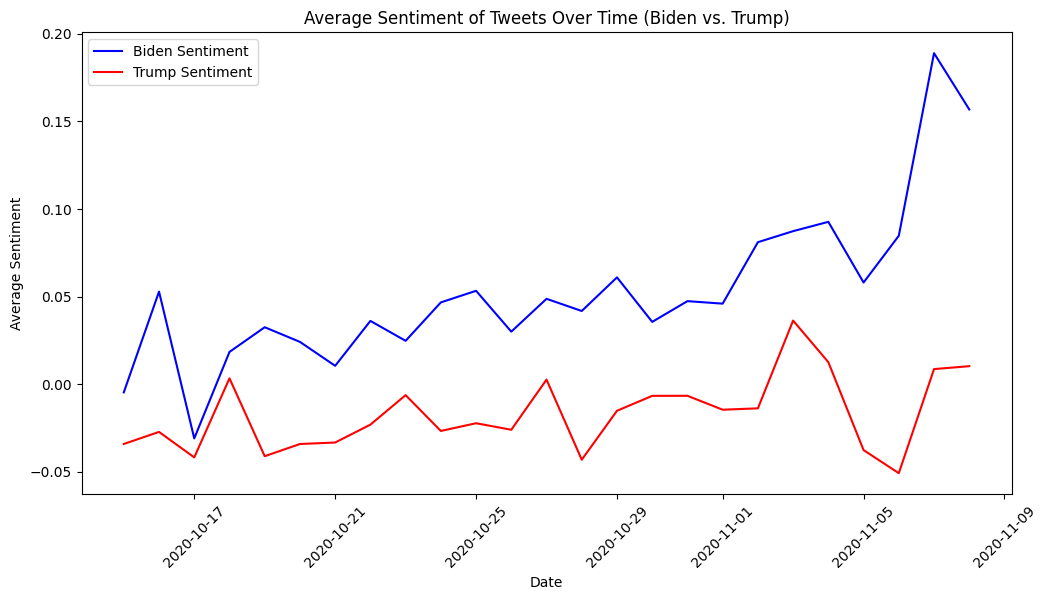

In [ ]:
# Convert the 'created_at' column to datetime
biden_df['date'] = pd.to_datetime(biden_df['created_at'])
trump_df['date'] = pd.to_datetime(trump_df['created_at'])

# Group by date and calculate the average sentiment per day
biden_daily_sentiment = biden_df.groupby(biden_df['date'].dt.date)['sentiment'].mean()
trump_daily_sentiment = trump_df.groupby(trump_df['date'].dt.date)['sentiment'].mean()

# Plot the sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(biden_daily_sentiment, label='Biden Sentiment', color='blue')
plt.plot(trump_daily_sentiment, label='Trump Sentiment', color='red')

plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment of Tweets Over Time (Biden vs. Trump)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Average sentiment score for each candidate
average_biden_sentiment = biden_df['sentiment'].mean()
average_trump_sentiment = trump_df['sentiment'].mean()

print(f"Average Sentiment for Biden: {average_biden_sentiment}")
print(f"Average Sentiment for Trump: {average_trump_sentiment}")

Average Sentiment for Biden: 0.0908565032543525
Average Sentiment for Trump: -0.011979348859817824


In [ ]:
# Add target labels for each candidate
biden_df['target'] = 1  # 1 for Biden
trump_df['target'] = 0  # 0 for Trump

# Combine both DataFrames into a single DataFrame
df = pd.concat([biden_df[['sentiment', 'target']], trump_df[['sentiment', 'target']]])

# Split into features X and target y
X = df[['sentiment']]
y = df['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make Predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate Logistic Regression model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)
print(report_log_reg)

Logistic Regression Accuracy: 0.5585359848210536
              precision    recall  f1-score   support

           0       0.57      0.80      0.66     37787
           1       0.52      0.27      0.35     31256

    accuracy                           0.56     69043
   macro avg       0.55      0.53      0.51     69043
weighted avg       0.55      0.56      0.52     69043



In [ ]:
# Initialize and Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Make Predictions
y_pred_rfc = rfc.predict(X_test)

# Evaluate Random Forest model
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
report_rfc = classification_report(y_test, y_pred_rfc)
print("Random Forest Accuracy:", accuracy_rfc)
print(report_rfc)

Random Forest Accuracy: 0.5565517141491534
              precision    recall  f1-score   support

           0       0.56      0.86      0.68     37787
           1       0.53      0.19      0.28     31256

    accuracy                           0.56     69043
   macro avg       0.55      0.52      0.48     69043
weighted avg       0.55      0.56      0.50     69043



In [ ]:
# Convert Training and Testing Sets to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}

# Train Model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_xgb = (xgb_model.predict(dtest) > 0.5).astype(int)

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print(report_xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:49:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.56104166968411
              precision    recall  f1-score   support

           0       0.57      0.86      0.68     37787
           1       0.54      0.20      0.30     31256

    accuracy                           0.56     69043
   macro avg       0.55      0.53      0.49     69043
weighted avg       0.55      0.56      0.51     69043



<ipython-input-14-1d2048177e6c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Set2')


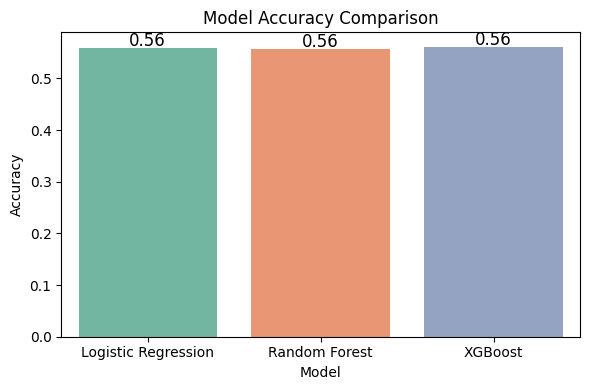

In [ ]:
# Store accuracy scores
accuracies = {
    'Logistic Regression': accuracy_log_reg,
    'Random Forest': accuracy_rfc,
    'XGBoost': accuracy_xgb
}

# Accuracy Comparison Bar Plot
plt.figure(figsize=(6, 4))  # Adjust size as needed
ax = sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Set2')

# Set Title and Labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Add Accuracy Labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top of each bar
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Display the plot
plt.tight_layout()
plt.show()

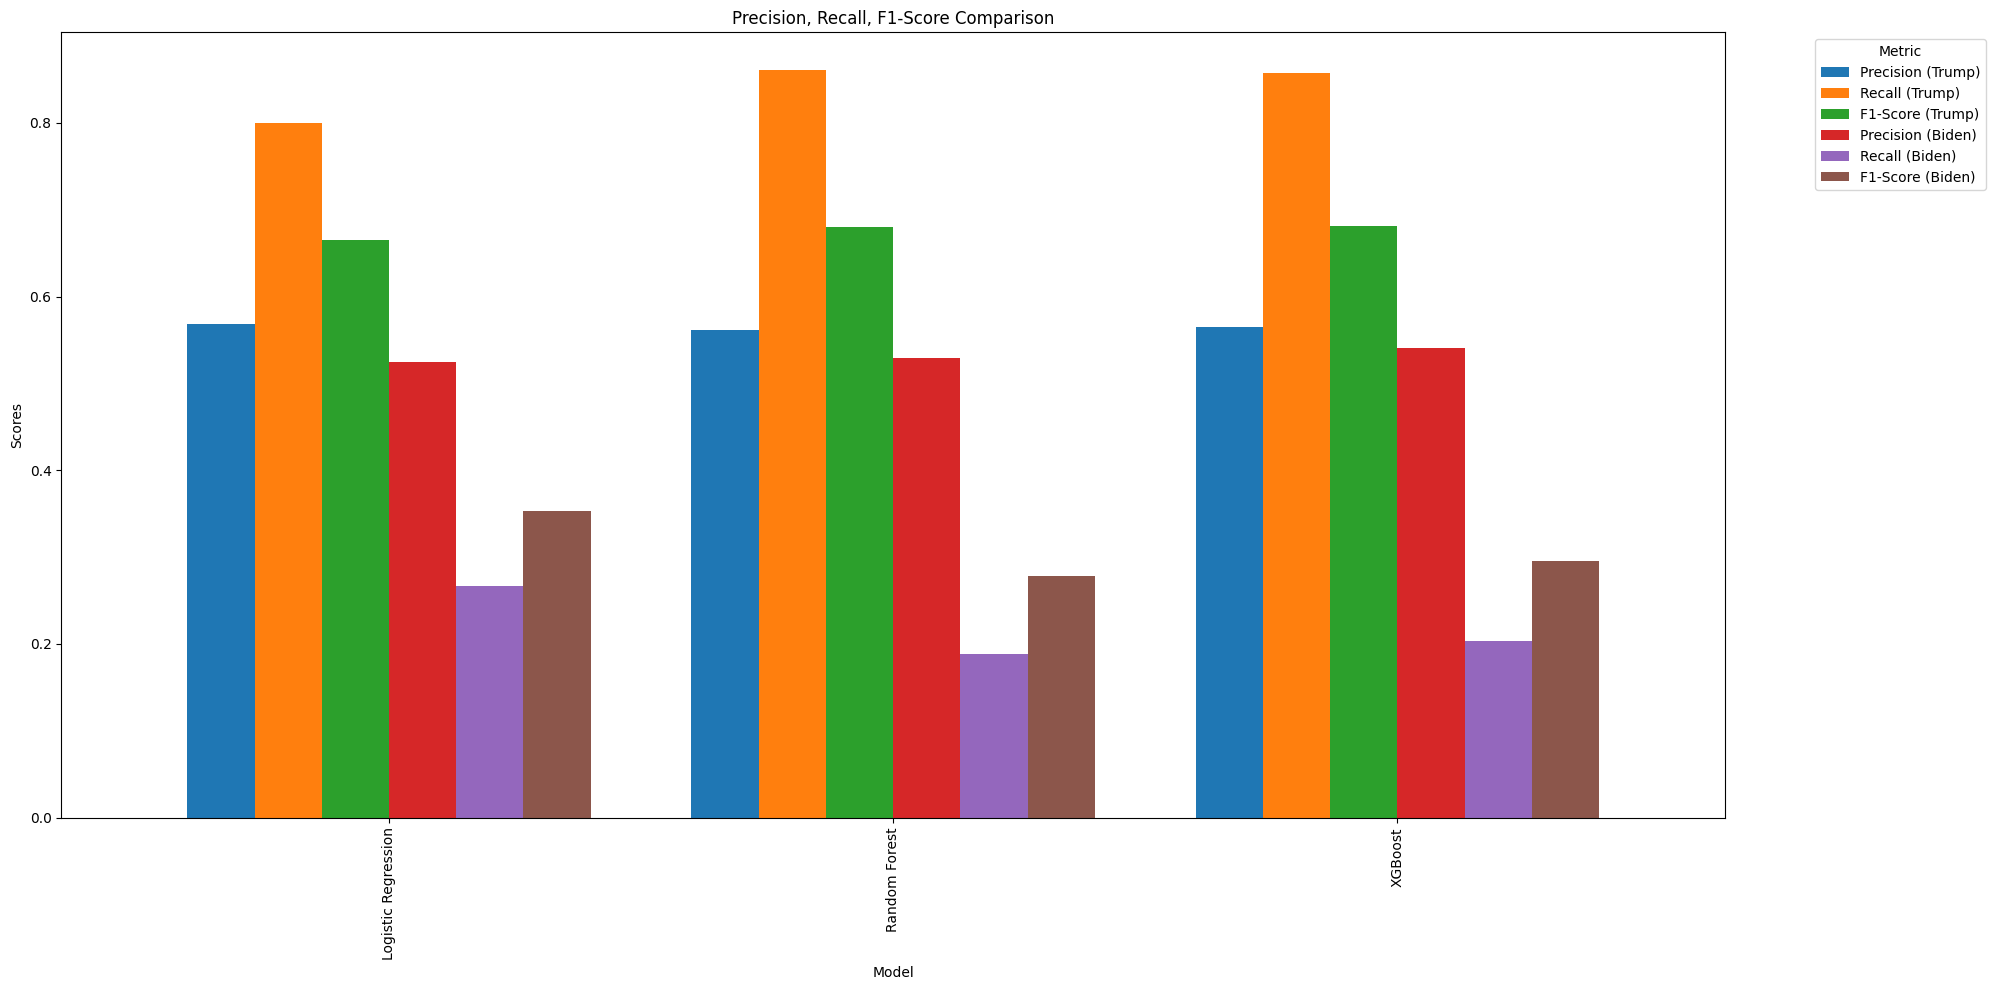

In [ ]:
# Convert classification reports to DataFrames for easier access
report_log_reg_df = pd.DataFrame(classification_report(y_test, y_pred_log_reg, output_dict=True)).transpose()
report_rfc_df = pd.DataFrame(classification_report(y_test, y_pred_rfc, output_dict=True)).transpose()
report_xgb_df = pd.DataFrame(classification_report(y_test, y_pred_xgb, output_dict=True)).transpose()

# Extract precision, recall, f1-score for each model and each class
metrics = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Precision (Trump)': [report_log_reg_df.loc['0', 'precision'], report_rfc_df.loc['0', 'precision'], report_xgb_df.loc['0', 'precision']],
    'Recall (Trump)': [report_log_reg_df.loc['0', 'recall'], report_rfc_df.loc['0', 'recall'], report_xgb_df.loc['0', 'recall']],
    'F1-Score (Trump)': [report_log_reg_df.loc['0', 'f1-score'], report_rfc_df.loc['0', 'f1-score'], report_xgb_df.loc['0', 'f1-score']],
    'Precision (Biden)': [report_log_reg_df.loc['1', 'precision'], report_rfc_df.loc['1', 'precision'], report_xgb_df.loc['1', 'precision']],
    'Recall (Biden)': [report_log_reg_df.loc['1', 'recall'], report_rfc_df.loc['1', 'recall'], report_xgb_df.loc['1', 'recall']],
    'F1-Score (Biden)': [report_log_reg_df.loc['1', 'f1-score'], report_rfc_df.loc['1', 'f1-score'], report_xgb_df.loc['1', 'f1-score']],
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Precision, Recall, F1-Score Comparison for each model
metrics_df.set_index('Model').plot(kind='bar',  figsize=(20, 10), width=0.8)
plt.title('Precision, Recall, F1-Score Comparison')
plt.ylabel('Scores')
plt.xlabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()